In [1]:
import os
import torch

print(torch.cuda.is_available())

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

d:\anaconda3\envs\gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [5]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(data="D:/TFM/TFM-DATOS/data.yaml", epochs=50, batch=32, optimizer='Adam')

Ultralytics YOLOv8.0.42  Python-3.9.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1060, 6144MiB)
yolo\engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/TFM/TFM-DATOS/data.yaml, epochs=20, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, o

In [1]:
import matplotlib.pyplot as plt

def predictImage(model, path, numImg, wantToPrint):
    
    width_images = 640
    height_images = 480

    result = model(f"{path}/{numImg}.png")
    
    if wantToPrint:
        res_plotted = result[0].plot()
        plt.imshow(res_plotted)
        plt.show()

    boxes = result[0].boxes

    listaBoxes = []

    for box in boxes:
        lista = box.xywhn[0].tolist()
        width = lista[2]
        height = lista[3]
        xmin = int((lista[0] - width/2) * width_images)
        ymin = int((lista[1] - height/2) * height_images)
        xmax = int((lista[0] + width/2) * width_images)
        ymax = int((lista[1] + height/2) * height_images)

        x_center = (xmax + xmin) / 2
        y_center = (ymax + ymin) / 2

        listaBoxes.append([x_center, y_center])
        if wantToPrint:
            print(f'{lista[0]},{lista[1]},{lista[2]},{lista[3]}')
    
    darknet_path = f"{path}/{numImg}.txt"
    
    listaDarknet = []
    
    with open(darknet_path, 'r') as f:
        for i, line in enumerate(f):
            class_index, x_center, y_center, width, height = map(float, line.strip().split())
            xmin = int((x_center - width/2) * width_images)
            ymin = int((y_center - height/2) * height_images)
            xmax = int((x_center + width/2) * width_images)
            ymax = int((y_center + height/2) * height_images)

            x_center = (xmax + xmin) / 2
            y_center = (ymax + ymin) / 2

            # listaDarknet.append([x_center, y_center])
            listaDarknet.append(([x_center, y_center],numImg))
            
    listaBoxes.sort()
    listaDarknet.sort()
    return listaBoxes, listaDarknet

In [2]:
import math

def esta_en_recta(punto1, punto2, punto3, tolerancia=0.01):
    x1, y1 = punto1
    x2, y2 = punto2
    x3, y3 = punto3

    # Calcular pendientes entre los dos puntos conocidos y entre uno de ellos y el tercer punto
    pendiente1 = (y2 - y1) / (x2 - x1) if (x2 - x1) != 0 else float('inf')
    pendiente2 = (y3 - y1) / (x3 - x1) if (x3 - x1) != 0 else float('inf')

    # Verificar si las pendientes son iguales dentro de una tolerancia
    if abs(pendiente1 - pendiente2) < tolerancia:
        x_tend = x1 - x2
        y_tend = y1 - y2

        sigue_x = (x_tend > 0 and (x2 - x3) > 0) or (x_tend < 0 and (x2 - x3) < 0) or (x_tend == 0 and (x2 - x3) == 0)
        sigue_y = (y_tend > 0 and (y2 - y3) > 0) or (y_tend < 0 and (y2 - y3) < 0) or (y_tend == 0 and (y2 - y3) == 0)

        return sigue_x and sigue_y

def calculate_distance(point1, point2):
    return math.dist(point1[1],point2[1]) / (point1[0] - point2[0])

def check_if_tupla_in_list(lista_tuplas, tupla, lista_final):
    for i in lista_tuplas:
        for j in i:
            if j == tupla:
                return True
    for i in lista_final:
        for j in i:
            if j == tupla:
                return True
    return False

In [3]:
def search_lines_of_sequence(primera_sequencia, segunda_sequencia, sequences, tol_pend, tol_dist, min_num_coords):

    lista_final = []

    for i_prim in primera_sequencia:

        lista_ordenada_por_distancia = []

        for i,tupla in enumerate(segunda_sequencia):
            seq1, seq2 = i_prim,segunda_sequencia[i]
            tupla_nueva = [(sequences.index(primera_sequencia) + 1, seq1), (sequences.index(segunda_sequencia) + 1, seq2)]
            lista_ordenada_por_distancia.append(tupla_nueva)
        
        for lista in lista_ordenada_por_distancia:
            for index, seq in enumerate(sequences):
                if seq != primera_sequencia and seq != segunda_sequencia:
                    menor = None
                    menor_tupla = None
                    for tupla in seq:
                        if not check_if_tupla_in_list(lista_ordenada_por_distancia, (index + 1, tupla), lista_final):
                            dist_ant = calculate_distance(lista[-2], lista[-1])
                            
                            dist = calculate_distance(lista[-1], (index + 1, tupla))

                            if lista[-2][0] > index + 1:
                                point1 = tupla
                                point2 = lista[-2][1]
                                point3 = lista[-1][1]
                            elif lista[-1][0] > index + 1:
                                point1 = lista[-2][1]
                                point2 = tupla
                                point3 = lista[-1][1]
                            else:
                                point1 = lista[-2][1]
                                point2 = lista[-1][1]
                                point3 = tupla

                            if esta_en_recta(point1, point2, point3, tol_pend) and ((abs(dist) - abs(dist_ant)) < tol_dist and (abs(dist) - abs(dist_ant)) > -tol_dist):
                                if menor == None or dist < menor:
                                    menor = dist
                                    menor_tupla = tupla
                    
                    if menor != None and menor_tupla != None:
                        # print(f"SE INSERTA: {(index + 1, menor_tupla)}")
                        lista.insert(index, (index + 1, menor_tupla))
                        lista.sort()

        max = None
        for i in lista_ordenada_por_distancia:
            if max == None:
                max = i
            elif len(i) > len(max):
                max = i
        if max != None:
            if len(max) > min_num_coords - 1:
                lista_final.append(max)
    
    return lista_final

In [4]:
def check_if_tupla_in_list_total(lista_total, lista):
    for i in lista:
        for j in lista_total:
            for x in j:
                if x == i:
                    return True
    return False

In [5]:
def search_for_objects(sequences, tol_pend, tol_dist, min_num_coords):

    lista_total = []

    for i in range(len(sequences)-1):
        lista_result = search_lines_of_sequence(sequences[i], sequences[i + 1], sequences, tol_pend, tol_dist, min_num_coords)
        for j in lista_result:
            if j not in lista_total and not check_if_tupla_in_list_total(lista_total, j):
                lista_total.append(j)

    return lista_total

In [6]:
def interpolate_points(start_point, end_point, num_points):
    # Calcula la distancia entre los puntos
    dx = (end_point[0] - start_point[0]) / (num_points + 1)
    dy = (end_point[1] - start_point[1]) / (num_points + 1)

    # Genera los puntos intermedios
    points = []
    for i in range(num_points):
        x = start_point[0] + dx * (i + 1)
        y = start_point[1] + dy * (i + 1)
        
        points.append((float("{:.2f}".format(x)), float("{:.2f}".format(y))))

    return points

def generate_next_point(prev_point, current_point):
    # Calcula la distancia entre los puntos
    dx = current_point[0] - prev_point[0]
    dy = current_point[1] - prev_point[1]

    # Calcula las coordenadas del siguiente punto
    next_x = current_point[0] + dx
    next_y = current_point[1] + dy

    return [(float("{:.2f}".format(next_x)), float("{:.2f}".format(next_y)))]

def generate_before_point(prev_point, current_point):
    # Calcula la distancia entre los puntos
    dx = prev_point[0] - current_point[0]
    dy = prev_point[1] - current_point[1]

    # Calcula las coordenadas del siguiente punto
    next_x = prev_point[0] + dx
    next_y = prev_point[1] + dy

    return [(float("{:.2f}".format(next_x)), float("{:.2f}".format(next_y)))]

def state_of_point(index_list, index):
    menor = None
    mayor = None
    for i in index_list:
        if i < index:
            if menor == None:
                menor = i
            else:
                if i > menor:
                    menor = i
        if i > index:
            if mayor == None:
                mayor = i
            else:
                if i < mayor:
                    mayor = i
    
    return menor, mayor

def complete_list(points_list):
    # Genera los puntos que faltan
    completed_list = points_list

    index_list = [i[0] for i in completed_list]

    for i in range(1,6):
        if i not in index_list:
            menor, mayor = state_of_point(index_list, i)
            points = None
            if menor != None and mayor != None:
                points = interpolate_points(points_list[index_list.index(menor)][1], points_list[index_list.index(mayor)][1], (mayor - menor) - 1)
            elif menor != None:
                if index_list.index(menor) - 1 >= 0:
                    prev = points_list[index_list.index(menor) - 1]
                cur = points_list[index_list.index(menor)]
                if prev != None and cur != None and cur[0] - prev[0] == 1:
                    points = generate_next_point(prev[1], cur[1])
            elif mayor != None:
                prev = points_list[index_list.index(mayor)]
                if index_list.index(mayor) + 1 < len(points_list):
                    cur = points_list[index_list.index(mayor) + 1]
                if prev != None and cur != None and cur[0] - prev[0] == 1:
                    points = generate_before_point(prev[1], cur[1])
            
            if points != None:
                suma = 1    
                for j in points:
                    if menor == None:
                        menor = 0
                    completed_list.append((menor + suma, j))
                    suma += 1
                completed_list.sort()
                index_list = [i[0] for i in completed_list]

    return completed_list

In [7]:
def postprocess_result(sequences, tol_pend, tol_dist, min_num_coords):
    lista = search_for_objects(sequences, tol_pend, tol_dist, min_num_coords)
    
    for i in lista:
        acabado = False
        while not acabado:
            complete_list(i)
            if len(i) == len(sequences):
                acabado = True

    return lista

In [8]:
def get_predicts_and_reals(model, path):

    predicts = []
    reals = []

    for i in range(1,6):
        listaBoxes, listaDarknet = predictImage(model, path, i, False)
        listaBoxesBuena = []
        listaDarknetBuena = []
        for j in listaBoxes:
            listaBoxesBuena.append((j[0], j[1]))

        for j in listaDarknet:
            listaDarknetBuena.append((j[0], j[1]))

        predicts.append(listaBoxesBuena)
        reals.append(listaDarknetBuena)

    return predicts, reals

In [9]:
def check_objects(predicts, reals, tolerancia, showLogs):
    predicts.sort()
    reals.sort()

    cantidad_objetos_detectados = 0

    reales_utilizadas = []

    lista_final_predicts = []
    lista_final_reals = []

    for p in predicts:
        esta = True
        real = None
        for t1 in p:
            estara = False
            for r in reals:
                real = r
                for t2 in r:
                    x = t1[0] - t2[0][0]
                    y = t1[1] - t2[0][1]
                    if abs(x) < tolerancia and abs(y) < tolerancia:
                        estara = True
                        break
                if estara:
                    break
            esta = esta and estara
        if esta and real not in reales_utilizadas:
            cantidad_objetos_detectados += 1
            reales_utilizadas.append(real)
            if showLogs:
                print(f"PREDICT: {p}")
                list_to_show_reals = [i[0] for i in real]
                print(f"REAL:    {list_to_show_reals}")
                print("-----------------------------------------------------------------------------------------")
            lista_final_predicts.append(p)
            lista_final_reals.append(real)
    if showLogs:
        print(f"Cantidad de objetos detectados: {cantidad_objetos_detectados}")
        print(f"Cantidad de objetos en la secuencia: {len(reals)}")

    return lista_final_predicts, (cantidad_objetos_detectados, len(reals))

In [30]:
import cv2
import matplotlib.pyplot as plt

def convert_list(lista):
    result = {}
    for sublist in lista:
        for item, index in sublist:
            if index not in result:
                result[index] = []
            result[index].append(item)

    final_list = list(result.values())
    return final_list

def transform_list(lista):
    result = {}
    for sublist in lista:
        for index, item in enumerate(sublist, start=1):
            if index not in result:
                result[index] = []
            result[index].append(item)

    final_list = list(result.values())
    return final_list

def show_images(path, predict, real):

    real_predict = transform_list(predict)

    height, width = 7, 7

    for i in range(len(real)):
        # print(f"----------FOTOGRAMA {i+1}----------")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        imgp = cv2.imread(f"{path}/{i+1}.png")
        imgr = cv2.imread(f"{path}/{i+1}.png")
        
        for j in real[i]:
            xmin = int(j[0][0] - width/2)
            ymin = int(j[0][1] - height/2)
            xmax = int(j[0][0] + width/2)
            ymax = int(j[0][1] + height/2)
            # print(f"xmin: {xmin}, xmax: {xmax}, ymin: {ymin}, ymax: {ymax}")
            cv2.rectangle(imgr, (xmin, ymin), (xmax, ymax), (0,255,0), thickness=1)
        
        ax1.imshow(imgr)
        ax1.set_title("REAL")

        # print(f"REAL")
        # plt.imshow(imgr)
        # plt.show()
        
        if len(real_predict) > 0:
            for j in real_predict[i]:
                xmin = int(j[0] - width/2)
                ymin = int(j[1] - height/2)
                xmax = int(j[0] + width/2)
                ymax = int(j[1] + height/2)
                # print(f"xmin: {xmin}, xmax: {xmax}, ymin: {ymin}, ymax: {ymax}")
                cv2.rectangle(imgp, (xmin, ymin), (xmax, ymax), (255,0,0), thickness=1)

        ax2.imshow(imgp)
        ax2.set_title("PREDICCIÓN")

        ax1.set_xlim(0, imgr.shape[1])
        ax1.set_ylim(imgr.shape[0], 0)
        ax2.set_xlim(0, imgp.shape[1])
        ax2.set_ylim(imgp.shape[0], 0)

        # print(f"PREDECIDA")
        # plt.imshow(imgp)

        plt.tight_layout()

        plt.show()

In [11]:
def start(model, path, tol_pend, tol_dist, tol_box, min_num_coords, showLogs):
    predicts, reals = get_predicts_and_reals(model, path)
    
    puntos_reales = []
    
    # for index, i in enumerate(reals[0]):
    #     lista_separada = [sublista[index] for sublista in reals]
    #     puntos_reales.append(lista_separada)
    
    for i in range(len(reals[0])):
        lista_separada = [j[i] for j in reals if len(j) > i]
        puntos_reales.append(lista_separada)
    
    results = postprocess_result(predicts, tol_pend, tol_dist, min_num_coords)
    
    lista_final = []

    for index, i in enumerate(results):
        lista_limpia = [j[1] for j in i]
        lista_final.append(lista_limpia)
    
    lfp, resultados = check_objects(lista_final, puntos_reales, tol_box, showLogs)

    return lfp, reals, resultados

# HAY QUE MIRAR QUE HACER CUANDO SE DETECTA UN OBJETO Y SE CREAN SUS 5 COORDENADAS Y EN LOS REALES, SOLO SE DETECTAN 4 COORDENADAS PORQUE LA 5 SE HA IDO DE LA IMÁGEN

Ultralytics YOLOv8.0.42  Python-3.9.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1060, 6144MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 D:\TFM\TFM-DATOS\test\77\1.png: 480x640 2 satellites, 28.6ms
Speed: 1.9ms preprocess, 28.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 D:\TFM\TFM-DATOS\test\77\2.png: 480x640 2 satellites, 29.9ms
Speed: 2.0ms preprocess, 29.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 D:\TFM\TFM-DATOS\test\77\3.png: 480x640 3 satellites, 19.3ms
Speed: 2.0ms preprocess, 19.3ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 D:\TFM\TFM-DATOS\test\77\4.png: 480x640 2 satellites, 19.9ms
Speed: 2.5ms preprocess, 19.9ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 D:\TFM\TFM-DATOS\test\77\5.png: 480x640 2 satellites, 23.8ms
Speed: 2.0ms preprocess, 23.8ms inference, 2.5ms postprocess per image at

PREDICT: [(442.0, 393.5), (464.5, 413.5), (486.5, 434.5), (508.5, 455.5), (530.5, 476.5)]
REAL:    [[441.5, 393.5], [463.5, 413.5], [485.5, 433.5], [507.5, 453.5], [529.5, 473.5]]
-----------------------------------------------------------------------------------------
Cantidad de objetos detectados: 1
Cantidad de objetos en la secuencia: 3


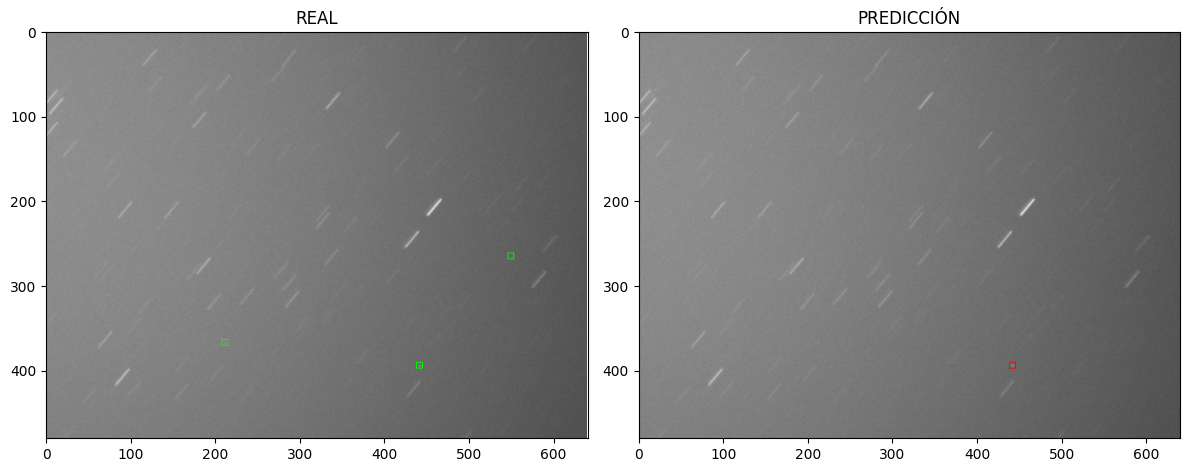

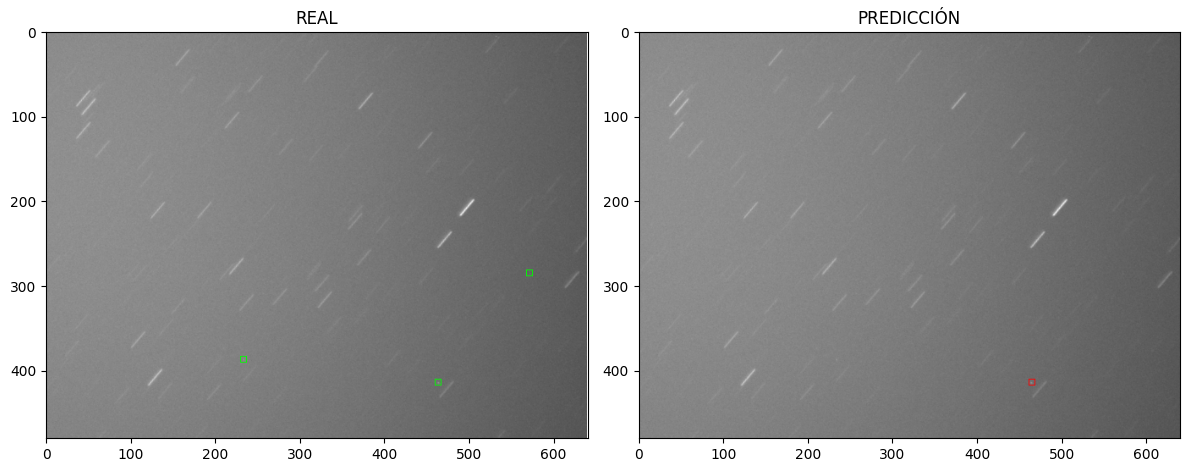

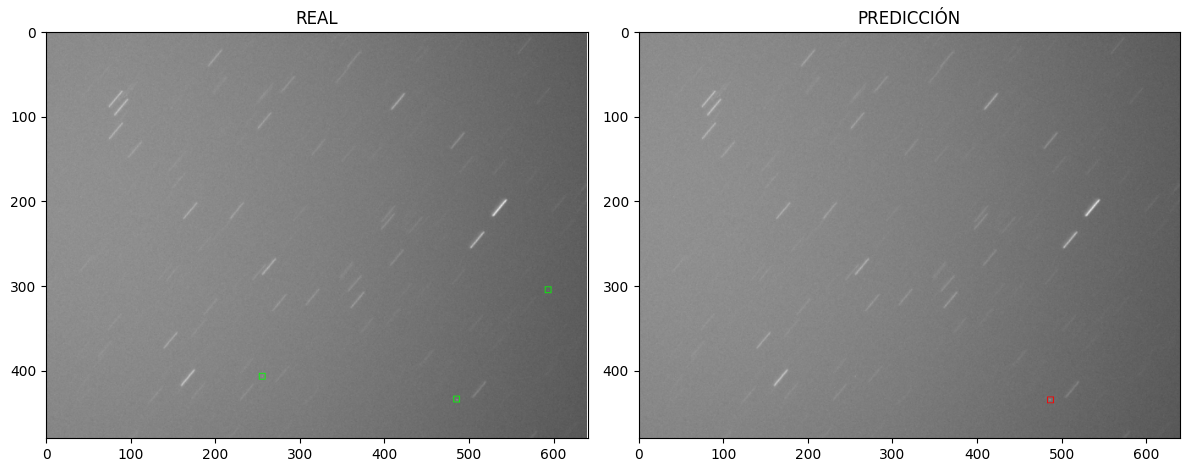

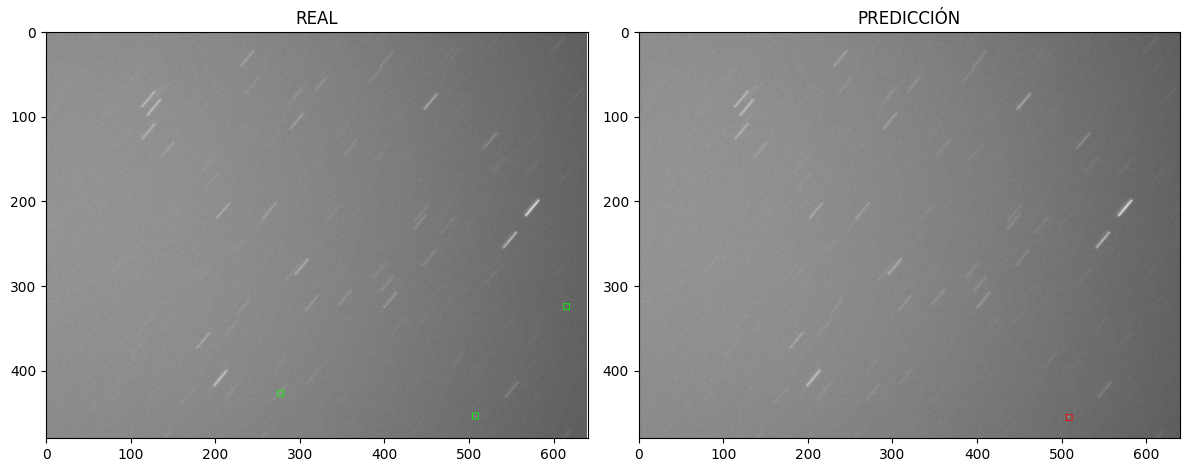

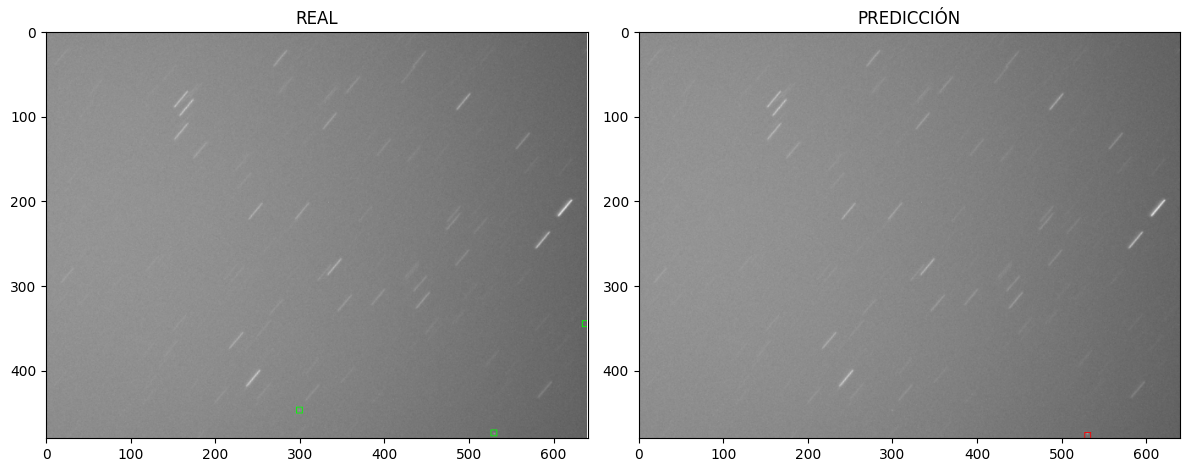

In [36]:
from ultralytics import YOLO

model = YOLO("D:/Nextcloud/memoria-scripts/TFM/runs/detect/0.75/weights/best.pt")

path = "D:/TFM/TFM-DATOS/test/77"

predicted, reals, resultados = start(model, path, tol_pend=11, tol_dist=1, tol_box=15, min_num_coords=3, showLogs=True)

show_images(path, predicted, reals)

In [ ]:
from ultralytics import YOLO

model = YOLO("D:/Nextcloud/memoria-scripts/TFM/runs/detect/0.75/weights/best.pt")

path = "C:/TFM/TFM-DATOS/train"

resultados_totales = {"predicted": 0, "reals": 0}

for i in range(1,101):
    path_sequence = f"{path}/{i}"
    _, _, resultados = start(model, path_sequence, tol_pend=1, tol_dist=1, tol_box=15, min_num_coords=3, showLogs=False)

    resultados_totales["predicted"] += resultados[0]
    resultados_totales["reals"] += resultados[1]

print("---------------------------------------")
print("---------------------------------------")
print("---------------------------------------")
print("---------------------------------------")
print(f"PREDECIDOS: {resultados_totales['predicted']}")
print(f"REALES: {resultados_totales['reals']}")

Ultralytics YOLOv8.0.42  Python-3.9.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1060, 6144MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 C:\TFM\TFM-DATOS\train\1\1.png: 480x640 3 satellites, 18.8ms
Speed: 1.0ms preprocess, 18.8ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\TFM\TFM-DATOS\train\1\2.png: 480x640 3 satellites, 20.7ms
Speed: 1.0ms preprocess, 20.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\TFM\TFM-DATOS\train\1\3.png: 480x640 3 satellites, 18.2ms
Speed: 0.0ms preprocess, 18.2ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\TFM\TFM-DATOS\train\1\4.png: 480x640 2 satellites, 21.8ms
Speed: 0.0ms preprocess, 21.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\TFM\TFM-DATOS\train\1\5.png: 480x640 4 satellites, 21.3ms
Speed: 1.0ms preprocess, 21.3ms inference, 3.0ms postprocess per image at

---------------------------------------
---------------------------------------
---------------------------------------
---------------------------------------
PREDECIDOS: 153
REALES: 198


In [ ]:
print(f"PREDECIDOS: {resultados_totales['predicted']}")
print(f"REALES: {resultados_totales['reals']}")
print(f"ACIERTO DEL: {resultados_totales['predicted']/resultados_totales['reals']}")

NameError: name 'resultados_totales' is not defined